<a href="https://colab.research.google.com/github/kanpiromnida-cmd/madt7204-vibecoding/blob/main/Meowzon_Cat_Shop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title
from IPython.display import display, HTML

def render_meowzon_header(customer_email="guest", cart_items=0, cart_products=0):
    display(HTML(f"""
    <style>
      @import url('https://fonts.googleapis.com/css2?family=Baloo+2:wght@600;700;800&family=Nunito:wght@500;700;800&display=swap');

      .mz-header {{
        border-radius: 14px;
        overflow: hidden;
        box-shadow: 0 8px 20px rgba(0,0,0,.10);
        margin: 8px 0 14px 0;
      }}

      .mz-top {{
        background: linear-gradient(135deg, #101820 0%, #172433 55%, #203247 100%);
        color: #fff;
        padding: 12px 16px;
        display: flex;
        align-items: center;
        justify-content: space-between;
        gap: 12px;
      }}

      .mz-brand {{
        display: flex;
        align-items: baseline;
        gap: 8px;
      }}

      .mz-logo {{
        font-family: "Baloo 2", cursive;
        font-size: 30px;
        font-weight: 800;
        letter-spacing: .3px;
        color: #ffffff;
        line-height: 1;
      }}

      .mz-logo .accent {{
        color: #ffad1f;
      }}

      .mz-tag {{
        font-family: "Nunito", sans-serif;
        font-size: 12px;
        font-weight: 800;
        text-transform: uppercase;
        letter-spacing: .12em;
        color: #f8cd7d;
      }}

      .mz-right {{
        display: flex;
        align-items: center;
        gap: 10px;
        font-family: "Nunito", sans-serif;
      }}

      .mz-user {{
        font-size: 13px;
        color: #d9e3ee;
      }}

      .mz-cart {{
        background: #2a3c52;
        border: 1px solid #47617f;
        color: #ffe1a3;
        border-radius: 999px;
        padding: 6px 12px;
        font-size: 13px;
        font-weight: 800;
      }}

      .mz-bottom {{
        background: #253446;
        color: #ecf2f8;
        padding: 8px 16px;
        font-family: "Nunito", sans-serif;
        font-size: 13px;
      }}

      .mz-bottom .dot {{
        margin: 0 8px;
        color: #9bb1c8;
      }}
    </style>

    <div class="mz-header">
      <div class="mz-top">
        <div class="mz-brand">
          <div class="mz-logo">meow<span class="accent">zon</span></div>
          <div class="mz-tag">Cat Shop</div>
        </div>
        <div class="mz-right">
          <div class="mz-user">Signed in: <b>{customer_email}</b></div>
          <div class="mz-cart">Cart: {cart_items} item(s) • {cart_products} product(s)</div>
        </div>
      </div>
      <div class="mz-bottom">
        Food <span class="dot">•</span> Treats <span class="dot">•</span> Toys <span class="dot">•</span> Litter <span class="dot">•</span> Furniture
      </div>
    </div>
    """))

# Example
render_meowzon_header("catlover@example.com", cart_items=3, cart_products=2)


In [ ]:
# @title
# =========================================================
# Cat Shop Mini-Shop (Google Colab)
# Amazon-style UI + FIXED cart limit (max 5 total items)
# =========================================================

import smtplib
from email.message import EmailMessage
from getpass import getpass
from IPython.display import display, HTML, clear_output

# -------------------------
# Global Config
# -------------------------
CURRENCY = "THB"
MAX_DIFFERENT_ITEMS = 5
MAX_TOTAL_ITEMS = 5  # FIX: total quantity across cart cannot exceed 5

SMTP_SERVER = "smtp.gmail.com"
SMTP_PORT = 587

# Optional fallback (recommended: Colab Secrets instead)
SENDER_EMAIL = "kanpirom.nida@gmail.com"
SENDER_PASSWORD = "gwpf rtgt bsus blyq"

DEMO_ACCOUNTS = {
    "catlover@example.com": "meow123",
    "alice@example.com": "cat456",
}

# -------------------------
# UI / Theme
# -------------------------
def render_theme():
    display(HTML("""
    <style>
      @import url('https://fonts.googleapis.com/css2?family=Nunito:wght@400;600;700;800&display=swap');
      body, .output, .output_area { font-family: 'Nunito', sans-serif; }

      .mz-nav {
        background: #131921; color: #fff; border-radius: 10px 10px 0 0;
        padding: 12px 16px; display: flex; justify-content: space-between; align-items: center;
      }
      .mz-brand { font-size: 20px; font-weight: 800; letter-spacing: .2px; }
      .mz-brand span { color: #ff9900; }
      .mz-user { font-size: 13px; opacity: .95; }
      .mz-cart-pill {
        background: #232f3e; color: #ffdd99; border: 1px solid #3d4f66;
        padding: 6px 10px; border-radius: 999px; margin-left: 8px; font-weight: 700;
      }
      .mz-subnav { background: #232f3e; color: #f3f3f3; border-radius: 0 0 10px 10px; padding: 8px 16px; font-size: 13px; }

      .mz-grid { display: grid; grid-template-columns: repeat(auto-fit, minmax(230px, 1fr)); gap: 12px; margin-top: 14px; }
      .mz-card {
        background: #fff; border: 1px solid #e3e6e6; border-radius: 10px; padding: 12px;
        box-shadow: 0 2px 8px rgba(0,0,0,.04);
      }
      .mz-card.mz-out { opacity: .78; background: #fcfcfc; }
      .mz-cat { font-size: 11px; color: #6b7280; font-weight: 700; text-transform: uppercase; margin-bottom: 6px; }
      .mz-name { font-size: 15px; color: #111; font-weight: 800; min-height: 40px; }
      .mz-id { margin-top: 6px; font-size: 12px; color: #374151; }
      .mz-price { font-size: 18px; color: #111; font-weight: 800; margin: 8px 0 4px; }
      .mz-stock { font-size: 12px; font-weight: 700; display: inline-block; padding: 4px 8px; border-radius: 999px; }
      .mz-stock.ok { color: #065f46; background: #d1fae5; }
      .mz-stock.bad { color: #991b1b; background: #fee2e2; }
      .mz-cta {
        margin-top: 10px; background: #ffd814; border: 1px solid #fcd200; color: #0f1111;
        font-weight: 700; font-size: 12px; border-radius: 20px; padding: 6px 10px; display: inline-block;
      }
      .mz-cta.disabled { background: #e5e7eb; border-color: #d1d5db; color: #6b7280; }

      .mz-cart { margin-top: 16px; display: grid; grid-template-columns: 2.2fr 1fr; gap: 12px; }
      .mz-panel { background: #fff; border: 1px solid #e3e6e6; border-radius: 10px; padding: 14px; }
      .mz-panel h3 { margin: 0 0 10px; color: #111; font-weight: 800; }
      .mz-row {
        display: flex; justify-content: space-between; gap: 10px; padding: 8px 0;
        border-bottom: 1px solid #f1f2f2; font-size: 14px;
      }
      .mz-row:last-child { border-bottom: none; }
      .mz-checkout {
        margin-top: 10px; width: 100%; border: 1px solid #fcd200; background: #ffd814;
        color: #0f1111; border-radius: 20px; padding: 8px 10px; font-weight: 800; text-align: center;
      }
      .mz-muted { color: #4b5563; font-size: 13px; }

      @media (max-width: 900px) { .mz-cart { grid-template-columns: 1fr; } }
    </style>
    """))


def render_topbar(customer_email="guest", unique_count=0, total_qty=0):
    display(HTML(f"""
    <div class="mz-nav">
      <div class="mz-brand">meow<span>zon</span> cat shop</div>
      <div class="mz-user">
        Signed in: <b>{customer_email}</b>
        <span class="mz-cart-pill">Cart: {total_qty} item(s), {unique_count} product(s)</span>
      </div>
    </div>
    <div class="mz-subnav">Food, treats, toys, litter, furniture & accessories</div>
    """))


# -------------------------
# Required Functions
# -------------------------
def authenticate_user():
    print("=== 1) Google Colab Authentication ===")
    try:
        from google.colab import auth as colab_auth
        colab_auth.authenticate_user()
        print("Colab native auth successful.")
    except Exception as e:
        print(f"Colab auth failed: {e}")
        return None

    print("\n=== 2) Cat Shop Login ===")
    email = input("Customer email: ").strip().lower()
    password = getpass("Password: ").strip()

    if DEMO_ACCOUNTS.get(email) == password:
        print("Login successful.")
        return email

    print("Authentication failed: invalid email/password.")
    return None


def load_products():
    return {
        "C01": {"product_id": "C01", "name": "Premium Salmon Kibble 1kg", "price": 320, "stock": 12, "category": "Food"},
        "C02": {"product_id": "C02", "name": "Chicken Wet Food Can", "price": 55, "stock": 25, "category": "Food"},
        "C03": {"product_id": "C03", "name": "Tuna Wet Food Can", "price": 60, "stock": 20, "category": "Food"},
        "C04": {"product_id": "C04", "name": "Grain-Free Dry Food 1kg", "price": 390, "stock": 9, "category": "Food"},
        "C05": {"product_id": "C05", "name": "Kitten Milk Replacer", "price": 280, "stock": 6, "category": "Food"},
        "C06": {"product_id": "C06", "name": "Chicken Bite Treats", "price": 99, "stock": 18, "category": "Treats"},
        "C07": {"product_id": "C07", "name": "Freeze-Dried Minnows", "price": 135, "stock": 11, "category": "Treats"},
        "C08": {"product_id": "C08", "name": "Catnip Crunch Treats", "price": 110, "stock": 14, "category": "Treats"},
        "C09": {"product_id": "C09", "name": "Automatic Feeder", "price": 1490, "stock": 0, "category": "Accessories"},
        "C10": {"product_id": "C10", "name": "Ceramic Water Fountain", "price": 990, "stock": 4, "category": "Accessories"},
        "C11": {"product_id": "C11", "name": "Scratching Post", "price": 450, "stock": 7, "category": "Furniture"},
        "C12": {"product_id": "C12", "name": "Cat Tree (Medium)", "price": 1890, "stock": 3, "category": "Furniture"},
        "C13": {"product_id": "C13", "name": "Feather Wand Toy", "price": 120, "stock": 22, "category": "Toys"},
        "C14": {"product_id": "C14", "name": "Laser Toy", "price": 190, "stock": 0, "category": "Toys"},
        "C15": {"product_id": "C15", "name": "Interactive Puzzle Toy", "price": 330, "stock": 8, "category": "Toys"},
        "C16": {"product_id": "C16", "name": "Clumping Cat Litter 10L", "price": 210, "stock": 13, "category": "Litter"},
        "C17": {"product_id": "C17", "name": "Odor Control Litter 10L", "price": 260, "stock": 0, "category": "Litter"},
        "C18": {"product_id": "C18", "name": "Litter Scoop", "price": 65, "stock": 30, "category": "Litter"},
        "C19": {"product_id": "C19", "name": "Cozy Cat Bed", "price": 520, "stock": 5, "category": "Accessories"},
        "C20": {"product_id": "C20", "name": "Harness & Leash Set", "price": 340, "stock": 6, "category": "Accessories"},
    }


def show_menu(products, customer_email="guest", unique_count=0, total_qty=0):
    render_topbar(customer_email, unique_count, total_qty)

    cards = []
    for pid in sorted(products.keys()):
        p = products[pid]
        out = p["stock"] == 0
        stock_html = '<span class="mz-stock bad">Out of Stock</span>' if out else f'<span class="mz-stock ok">In Stock ({p["stock"]})</span>'
        card_class = "mz-card mz-out" if out else "mz-card"
        cta_class = "mz-cta disabled" if out else "mz-cta"
        cta_text = "Unavailable" if out else "Add by Product ID"

        cards.append(f"""
        <div class="{card_class}">
          <div class="mz-cat">{p["category"]}</div>
          <div class="mz-name">{p["name"]}</div>
          <div class="mz-id">ID: <b>{p["product_id"]}</b></div>
          <div class="mz-price">{p["price"]:.2f} {CURRENCY}</div>
          {stock_html}<br/>
          <span class="{cta_class}">{cta_text}</span>
        </div>
        """)

    display(HTML(f'<div class="mz-grid">{"".join(cards)}</div>'))


def render_cart_preview(cart, title="Shopping Cart"):
    total_qty = sum(item["quantity"] for item in cart)
    total_cost = sum(item["subtotal"] for item in cart)
    unique_count = len(cart)

    if not cart:
        left_html = '<p class="mz-muted">Your cart is empty.</p>'
    else:
        rows = []
        for item in cart:
            rows.append(
                f'<div class="mz-row"><div>{item["quantity"]} x {item["name"]}</div><div>{item["subtotal"]:.2f} {CURRENCY}</div></div>'
            )
        left_html = "".join(rows)

    display(HTML(f"""
    <div class="mz-cart">
      <div class="mz-panel">
        <h3>{title}</h3>
        {left_html}
      </div>
      <div class="mz-panel">
        <h3>Order Summary</h3>
        <div class="mz-row"><div>Total Units (max {MAX_TOTAL_ITEMS})</div><div>{total_qty}</div></div>
        <div class="mz-row"><div>Different Products (max {MAX_DIFFERENT_ITEMS})</div><div>{unique_count}</div></div>
        <div class="mz-row"><div>Subtotal</div><div>{total_cost:.2f} {CURRENCY}</div></div>
        <div class="mz-checkout">Proceed to Checkout</div>
      </div>
    </div>
    """))


def select_products(products, customer_email="guest"):
    """
    FIXED:
    - Max 5 different products
    - Max 5 total units across all selected products
    """
    cart = []
    selected_ids = set()
    message = "Add up to 5 total items (and max 5 different products). Type 'done' to finish."

    while True:
        total_qty = sum(item["quantity"] for item in cart)
        remaining_total = MAX_TOTAL_ITEMS - total_qty
        remaining_diff = MAX_DIFFERENT_ITEMS - len(cart)

        if remaining_total <= 0 or remaining_diff <= 0:
            message = "Cart limit reached."
            break

        clear_output(wait=True)
        render_theme()
        show_menu(products, customer_email, unique_count=len(cart), total_qty=total_qty)
        render_cart_preview(cart)
        print(message)

        product_id = input(
            f"Enter product_id ({remaining_diff} product slot(s), {remaining_total} item(s) left): "
        ).strip().upper()

        if product_id == "DONE":
            break

        if product_id not in products:
            message = "Invalid product_id. Try again."
            continue

        if product_id in selected_ids:
            message = "This product is already in your cart."
            continue

        product = products[product_id]
        if product["stock"] == 0:
            message = f"{product['name']} is Out of Stock."
            continue

        max_qty_allowed = min(product["stock"], remaining_total)
        qty_raw = input(f"Enter quantity for {product['name']} (max {max_qty_allowed}): ").strip()

        try:
            qty = int(qty_raw)
            if qty <= 0:
                message = "Quantity must be greater than 0."
                continue
        except ValueError:
            message = "Invalid quantity. Enter a whole number."
            continue

        if qty > max_qty_allowed:
            message = f"Quantity too high. You can add at most {max_qty_allowed}."
            continue

        product["stock"] -= qty
        selected_ids.add(product_id)
        cart.append({
            "product_id": product_id,
            "name": product["name"],
            "unit_price": product["price"],
            "quantity": qty,
            "subtotal": product["price"] * qty,
        })
        message = f"Added: {product['name']} x {qty}"

    return cart


def calculate_total(cart):
    total = 0.0
    for item in cart:
        item["subtotal"] = item["unit_price"] * item["quantity"]
        total += item["subtotal"]
    return total


def show_order_summary(cart, total, customer_email="guest"):
    clear_output(wait=True)
    render_theme()
    total_qty = sum(item["quantity"] for item in cart)
    render_topbar(customer_email, unique_count=len(cart), total_qty=total_qty)

    if not cart:
        display(HTML('<div class="mz-panel"><h3>Order Summary</h3><p class="mz-muted">No items selected.</p></div>'))
        return

    rows = []
    for item in cart:
        rows.append(
            f'<div class="mz-row"><div>{item["name"]} (x{item["quantity"]})</div><div>{item["subtotal"]:.2f} {CURRENCY}</div></div>'
        )

    display(HTML(f"""
    <div class="mz-cart">
      <div class="mz-panel">
        <h3>Order Summary</h3>
        {''.join(rows)}
      </div>
      <div class="mz-panel">
        <h3>Final Total</h3>
        <div class="mz-row"><div>Total Units</div><div>{total_qty}/{MAX_TOTAL_ITEMS}</div></div>
        <div class="mz-row"><div>Grand Total</div><div><b>{total:.2f} {CURRENCY}</b></div></div>
        <div class="mz-checkout">Confirm and Send Email</div>
      </div>
    </div>
    """))


def restore_stock(products, cart):
    for item in cart:
        products[item["product_id"]]["stock"] += item["quantity"]


def _configure_sender_credentials():
    global SENDER_EMAIL, SENDER_PASSWORD

    if SENDER_EMAIL and SENDER_PASSWORD:
        SENDER_PASSWORD = SENDER_PASSWORD.replace(" ", "")
        return True

    try:
        from google.colab import userdata
        if not SENDER_EMAIL:
            SENDER_EMAIL = (userdata.get("SENDER_EMAIL") or "").strip()
        if not SENDER_PASSWORD:
            # Recommended secret name for Gmail app password
            SENDER_PASSWORD = (userdata.get("SENDER_APP_PASSWORD") or userdata.get("SENDER_PASSWORD") or "").strip()
    except Exception:
        pass

    if not SENDER_EMAIL:
        SENDER_EMAIL = input("Sender Gmail: ").strip()
    if not SENDER_PASSWORD:
        SENDER_PASSWORD = getpass("Gmail App Password (16 chars): ").strip()

    SENDER_PASSWORD = SENDER_PASSWORD.replace(" ", "")
    return bool(SENDER_EMAIL and SENDER_PASSWORD)


def send_order_email(customer_email, cart, total):
    if not _configure_sender_credentials():
        print("Email not sent: missing sender credentials.")
        return False

    msg = EmailMessage()
    msg["Subject"] = "Cat Shop Order Confirmation"
    msg["From"] = SENDER_EMAIL
    msg["To"] = customer_email

    lines = [
        "Cat Shop Order Confirmation",
        "",
        f"Customer email: {customer_email}",
        "",
        "Ordered items:",
    ]
    for item in cart:
        lines.append(
            f"- {item['name']} | Qty: {item['quantity']} | Subtotal: {item['subtotal']:.2f} {CURRENCY}"
        )
    lines += [
        "",
        f"Grand total: {total:.2f} {CURRENCY}",
        "",
        "Thank you for your order! Your cat goodies are on the way."
    ]
    msg.set_content("\n".join(lines))

    try:
        with smtplib.SMTP(SMTP_SERVER, SMTP_PORT, timeout=20) as server:
            server.starttls()
            server.login(SENDER_EMAIL, SENDER_PASSWORD)
            server.send_message(msg)
        print("Order confirmation email sent successfully.")
        return True
    except smtplib.SMTPAuthenticationError as e:
        detail = e.smtp_error.decode("utf-8", errors="ignore") if isinstance(e.smtp_error, bytes) else str(e.smtp_error)
        print(f"Email send failed ({e.smtp_code}): {detail}")
        print("Use Gmail App Password (not normal password).")
        return False
    except Exception as e:
        print(f"Failed to send email: {e}")
        return False


# -------------------------
# Main Flow
# -------------------------
def main():
    clear_output(wait=True)
    render_theme()
    render_topbar("guest", 0, 0)

    customer_email = authenticate_user()
    if not customer_email:
        print("Flow stopped.")
        return

    _configure_sender_credentials()  # load once for loop
    products = load_products()

    while True:
        cart = select_products(products, customer_email=customer_email)

        if not cart:
            again = input("No items selected. Start a new order? (yes/no): ").strip().lower()
            if again != "yes":
                print("Session ended.")
                break
            continue

        # Safety check (never allow > MAX_TOTAL_ITEMS)
        if sum(i["quantity"] for i in cart) > MAX_TOTAL_ITEMS:
            print("Cart invalid: more than 5 total items. Please try again.")
            restore_stock(products, cart)
            continue

        total = calculate_total(cart)
        show_order_summary(cart, total, customer_email=customer_email)

        confirm = input("Do you want to confirm this cat order? (yes/no): ").strip().lower()
        if confirm == "yes":
            send_order_email(customer_email, cart, total)
        else:
            restore_stock(products, cart)
            print("Order cancelled. Stock restored.")

        again = input("Create another order and send another email? (yes/no): ").strip().lower()
        if again != "yes":
            print("Session ended. Thank you.")
            break


# Run
main()


Do you want to confirm this cat order? (yes/no): yes
Order confirmation email sent successfully.
Create another order and send another email? (yes/no): no
Session ended. Thank you.


# Read me


```mermaid

- When found an error below
Failed to send email: (534, b'5.7.9 Application-specific password required. For more information, go to\n5.7.9  https://support.google.com/mail/?p=InvalidSecondFactor 46e09a7af769-7d52d0725c4sm2823271a34.25 - gsmtp')


***Gmail blocked SMTP login because it needs an App Password (not your normal Gmail password).***

1. Turn on 2-Step Verification: https://myaccount.google.com/security
2. Generate App Password: https://myaccount.google.com/apppasswords
3. In Colab Secrets, add:
SENDER_EMAIL = your Gmail
SENDER_APP_PASSWORD = 16-char app password
4.Replace your email section.

```


# System Flow

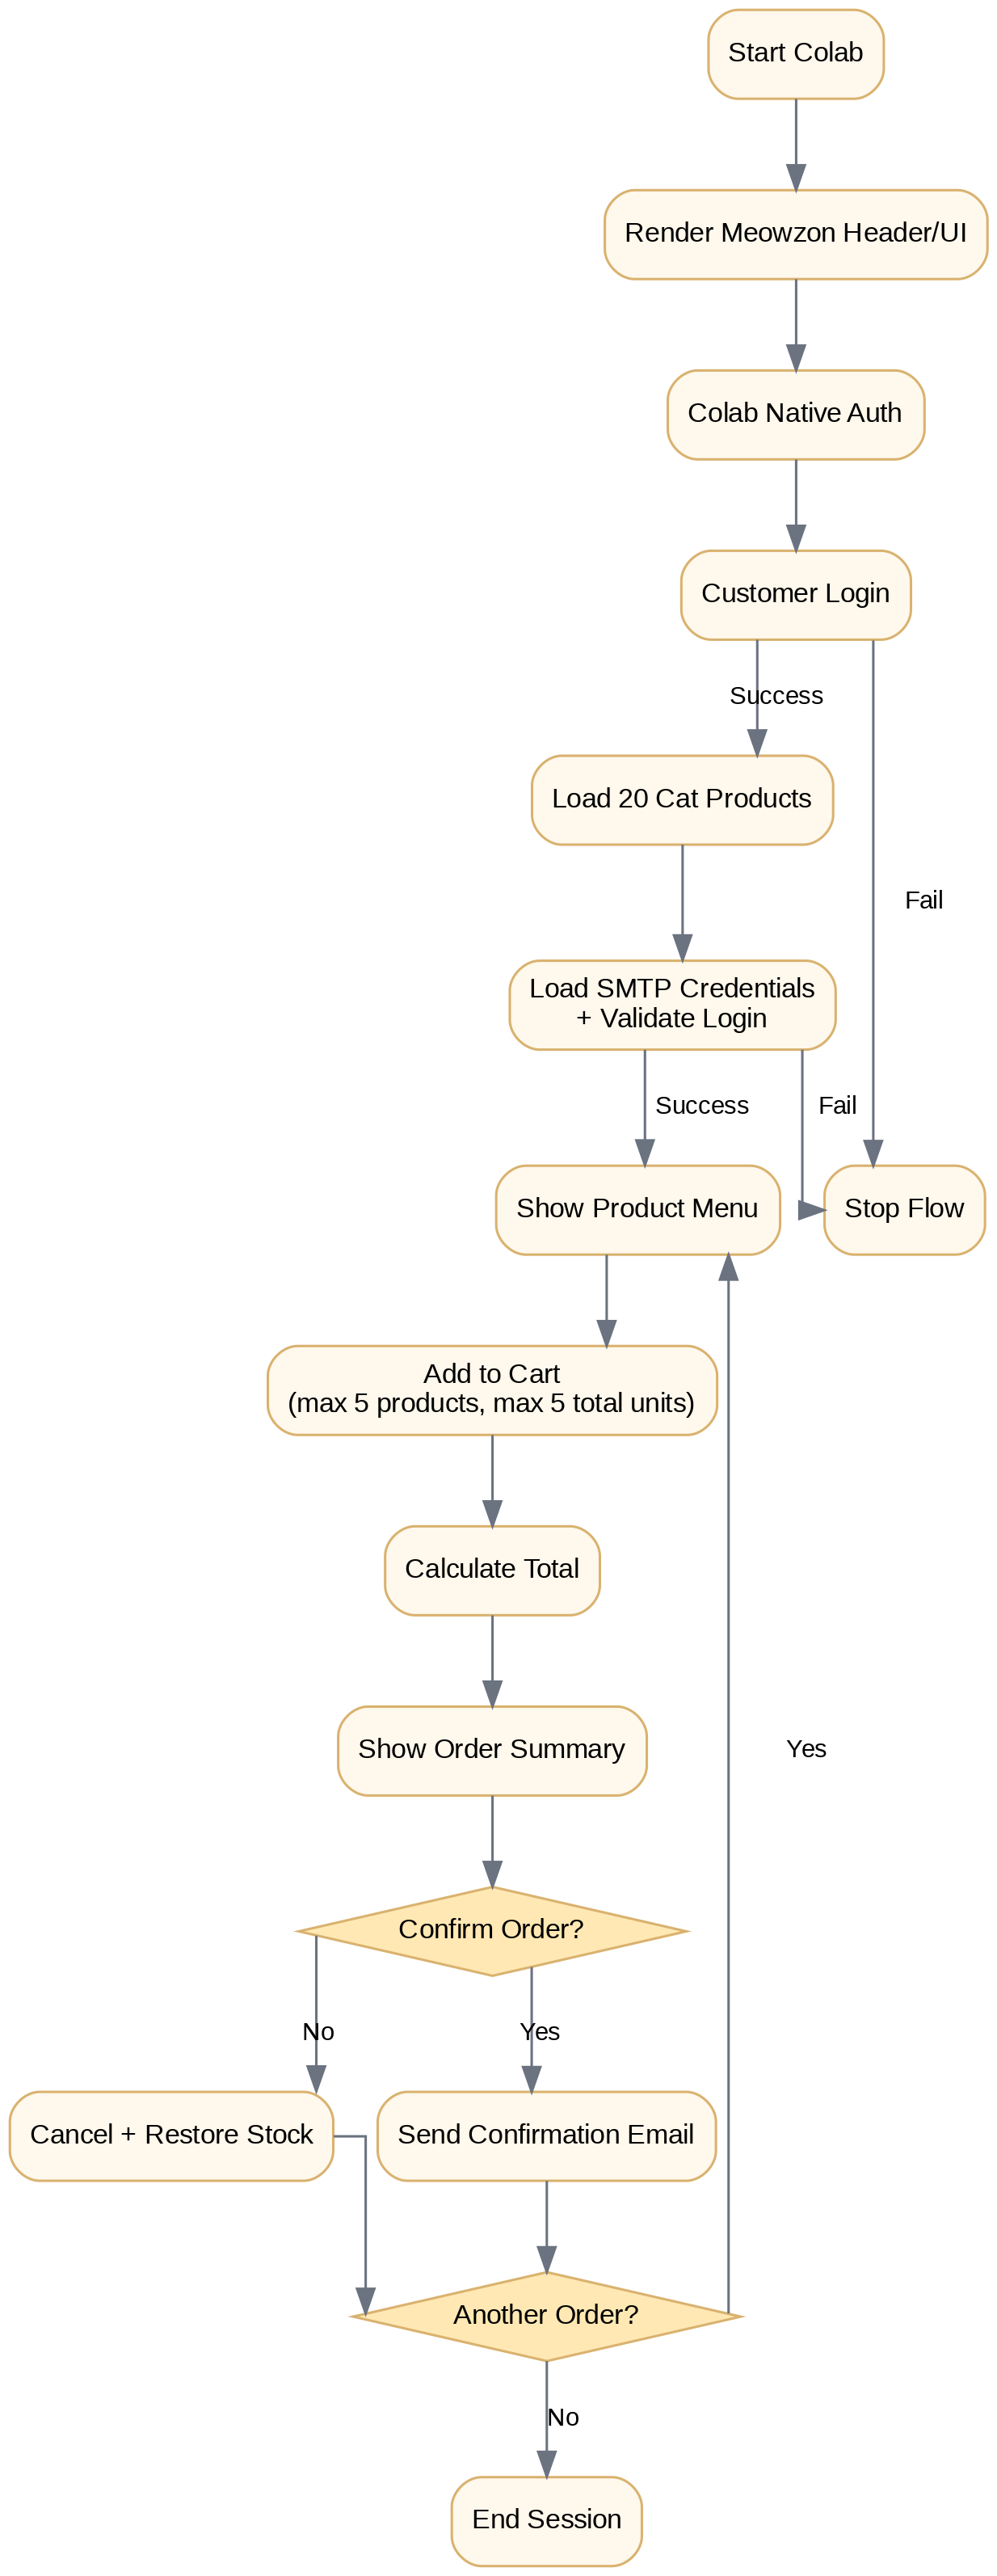



W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


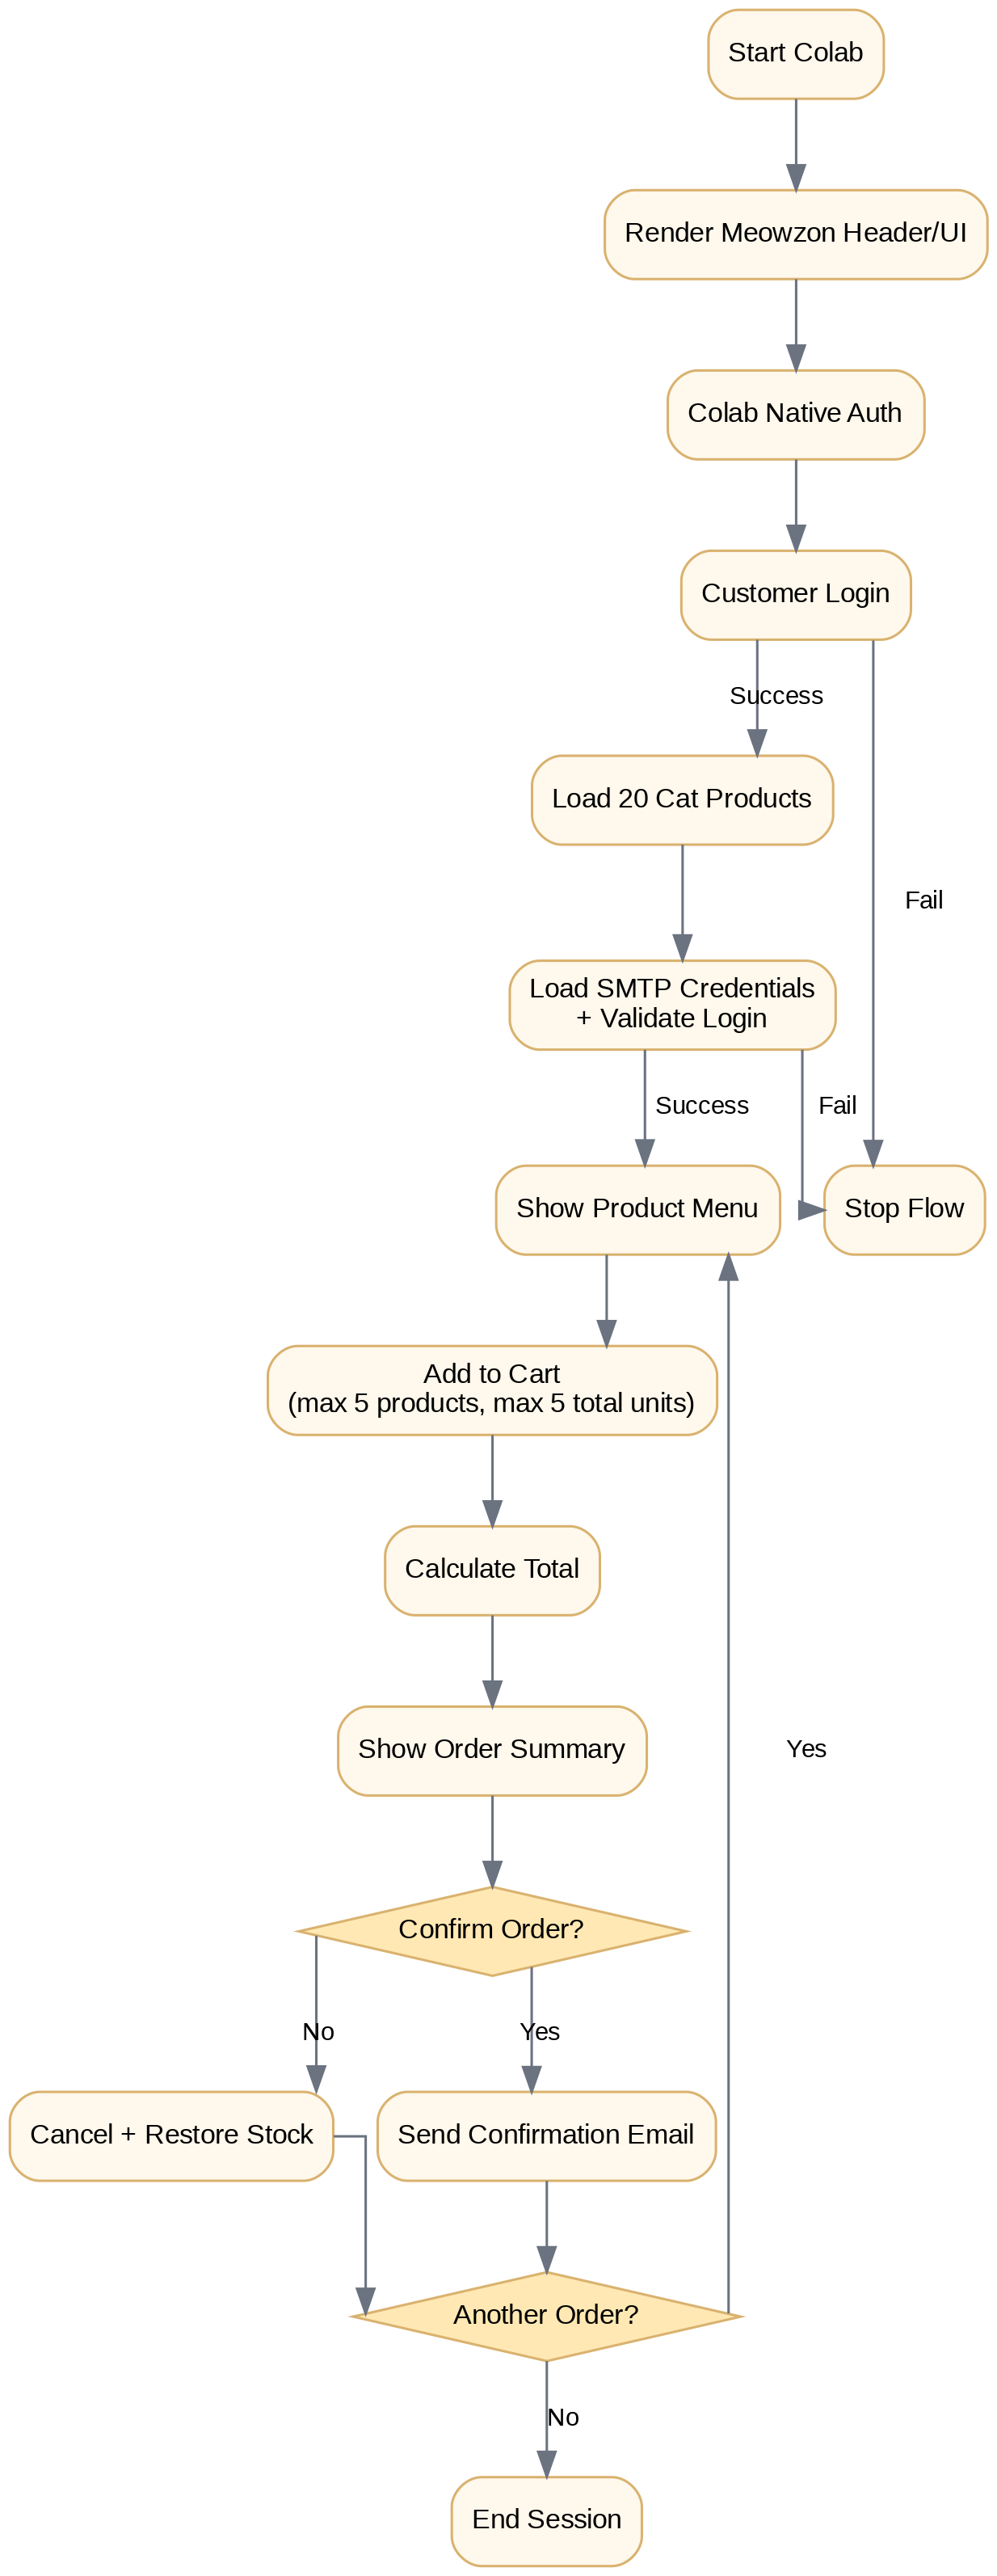

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# @title
!apt-get -qq update
!apt-get -qq install -y graphviz
!pip -q install graphviz
from graphviz import Digraph
from IPython.display import Image, display
from google.colab import files

dot = Digraph("MeowzonFlow", format="png")
dot.attr(rankdir="TB", splines="ortho", dpi="220", bgcolor="white")
dot.attr("node", shape="box", style="rounded,filled", fillcolor="#fff8ec",
         color="#d9b26f", fontname="Helvetica", fontsize="11")
dot.attr("edge", color="#6b7280", fontname="Helvetica", fontsize="10")

# Nodes
dot.node("A", "Start Colab")
dot.node("B", "Render Meowzon Header/UI")
dot.node("C", "Colab Native Auth")
dot.node("D", "Customer Login")
dot.node("E", "Load 20 Cat Products")
dot.node("F", "Load SMTP Credentials\\n+ Validate Login")
dot.node("G", "Show Product Menu")
dot.node("H", "Add to Cart\\n(max 5 products, max 5 total units)")
dot.node("I", "Calculate Total")
dot.node("J", "Show Order Summary")
dot.node("K", "Confirm Order?")
dot.node("L", "Cancel + Restore Stock")
dot.node("M", "Send Confirmation Email")
dot.node("N", "Another Order?")
dot.node("O", "End Session")
dot.node("Z", "Stop Flow")

# Decision styling
dot.node("K", "Confirm Order?", shape="diamond", style="filled", fillcolor="#ffe8b3")
dot.node("N", "Another Order?", shape="diamond", style="filled", fillcolor="#ffe8b3")

# Edges
dot.edge("A", "B")
dot.edge("B", "C")
dot.edge("C", "D")
dot.edge("D", "Z", label="Fail")
dot.edge("D", "E", label="Success")
dot.edge("E", "F")
dot.edge("F", "Z", label="Fail")
dot.edge("F", "G", label="Success")
dot.edge("G", "H")
dot.edge("H", "I")
dot.edge("I", "J")
dot.edge("J", "K")
dot.edge("K", "L", label="No")
dot.edge("K", "M", label="Yes")
dot.edge("L", "N")
dot.edge("M", "N")
dot.edge("N", "G", label="Yes")
dot.edge("N", "O", label="No")

png_file = dot.render("/content/meowzon_system_flow", cleanup=True)

display(Image(filename=png_file))
files.download(png_file)
